In [182]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
from statannot import add_stat_annotation
from scipy.stats import chisquare
from scipy import stats
from scipy.stats import spearmanr

import rpy2.rinterface
#ipython extension
%load_ext rpy2.ipython
from rpy2.robjects import pandas2ri
pandas2ri.activate()


#seaborn Gr-Bk-Rd palette
pal = sns.diverging_palette(127.7, 12.2, l=53.4, n=255, center="dark")

pd.set_option('display.max_columns', 500)

%R library(GEOquery)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['bindrcpp', 'GEOquery', 'Biobase', 'BiocGenerics', 'parallel',
       'tools', 'RevoUtils', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'RevoUtilsMath', 'methods', 'base'], dtype='<U13')

---
## TARGET-ALL

In [209]:
#data input
table = pd.read_csv("./cBioPotal/all_phase2_target_2018_pub_(pediatric)/all_phase2_target_2018_pub_clinical_data.csv")
rna = pd.read_csv("./cBioPotal/all_phase2_target_2018_pub_(pediatric)/data_expression_median.txt", sep = '\t', header = None).T

rna.columns = rna.iloc[0,:]
rna = rna[2:]

table = pd.merge(table, rna, left_on = 'Sample ID', right_on = 'Hugo_Symbol')

#########################################non-paired sample
m = (table['Sample ID'].str.contains('-04')) == True
m2 = (table['Sample ID'].str.contains('-09')) == True 

paired = pd.concat([table[m], table[m2]])
paired = paired.sort_values(by='Sample ID').reset_index()

paired['Relapse'] = paired['Sample ID'].str.contains('-04') == True

#data output
eset = paired.loc[:,'DDR1':'LOC652743']
pset = paired.loc[:, ['Sample ID', 'Relapse']]

#nomalize
eset2 = eset.apply(pd.to_numeric, errors='coerce')
#eset2 = eset2.apply(lambda x: np.log2(x)) 

eset2.to_csv('./cBioPotal/all_phase2_target_2018_pub_(pediatric)/eset.csv')
pset.to_csv('./cBioPotal/all_phase2_target_2018_pub_(pediatric)/pset.csv')

C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249

In [210]:
m = pset['Relapse'] == True

kif2c_r = eset2[m]['KIF2C']
kif2c_d = eset2[-m]['KIF2C']
kif18b_r = eset2[m]['LOC146909']
kif18b_d = eset2[-m]['LOC146909']
ncaph_r = eset2[m]['NCAPH']
ncaph_d = eset2[-m]['NCAPH']


dia = pd.DataFrame([kif2c_d, kif18b_d, ncaph_d]).T
rel = pd.DataFrame([kif2c_r, kif18b_r, ncaph_r]).T

dia.to_csv('./dia.csv', index=False)
rel.to_csv('./rel.csv', index=False)

In [ ]:
%%R

dia <- read.csv('./dia.csv')
rel <- read.csv('./rel.csv')

dianum = 134
relnum = 116

data <- data.frame(
  name=c( rep("KIF2C_diagnosis",dianum), rep("KIF2C_relapse",relnum), 
         rep("KIF18B_diagnosis",dianum), rep("KIF18B_relapse",relnum), 
         rep("NCAPH_diagnosis",dianum), rep("NCAPH_relapse",relnum)),
  
    value=c( dia[1:dianum,'KIF2C'], rel[1:relnum,'KIF2C'],
            dia[1:dianum,'LOC146909'], rel[1:relnum,'LOC146909'],
            dia[1:dianum,'NCAPH'], rel[1:relnum,'NCAPH']
           )
)

write.csv(data, './TARGET.csv', row.names=FALSE)

---
## Correlation

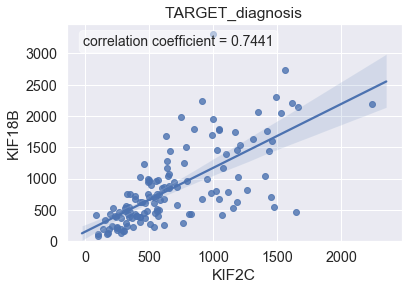

In [163]:
ax = sns.regplot(x = kif2c_d, y = kif18b_d)
ax.set(ylabel='KIF18B')
plt.title('TARGET_diagnosis')

ax.hist(0, 50)
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

corr = (spearmanr(kif2c_d, kif18b_d)[0])
textstr = 'correlation coefficient = %.4f' %(corr)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


plt.savefig('./TARGET_diagnosis_corr.png', dpi=300, bbox_inches='tight')

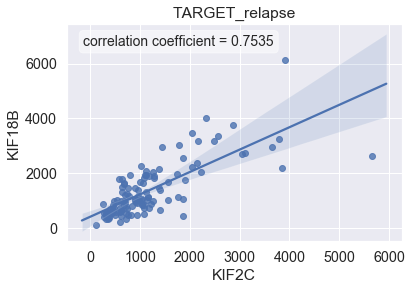

In [164]:
ax = sns.regplot(x = kif2c_r, y = kif18b_r)
ax.set(ylabel='KIF18B')
plt.title('TARGET_relapse')

ax.hist(0, 50)
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

corr = (spearmanr(kif2c_r, kif18b_r)[0])
textstr = 'correlation coefficient = %.4f' %(corr)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.savefig('./TARGET_relapse_corr.png', dpi=300, bbox_inches='tight')

In [116]:
print(stats.shapiro(kif2c_d))
print(stats.shapiro(kif18b_d))
print(stats.shapiro(kif2c_r))
print(stats.shapiro(kif18b_r))

print(spearmanr(kif2c_d, kif18b_d))
print(spearmanr(kif2c_r, kif18b_r))

(0.9160125851631165, 4.3233205815340625e-07)
(0.8814458250999451, 6.096354532303394e-09)
(0.7910801768302917, 1.4954624344420964e-11)
(0.8587296009063721, 3.916853952290467e-09)
SpearmanrResult(correlation=0.7440566590605868, pvalue=7.033005117964884e-25)
SpearmanrResult(correlation=0.7535001729904278, pvalue=1.693654071889137e-22)


---
## TARGET-ALL paired sample

In [1]:
with open("./cBioPotal/all_phase2_target_2018_pub_(pediatric)/pset.csv") as f:
    lines = f.readlines()

result = [lines[0]]

total_samplelist = []

for line in lines[1:]:
    lsp = line.strip().split(',')
    sample_name = lsp[1][0:-3]
    total_samplelist.append(sample_name)

no_dup = list(set(total_samplelist))

paired_only = []

for nps in no_dup:
    total_samplelist.remove(nps)

print(total_samplelist)

for line in lines[1:]:
    lsp = line.strip().split(',')
    if lsp[1][0:-3] in total_samplelist:
        result.append(line)

with open('dup_only.csv','w') as sv:
    sv.write(''.join(result))

['TARGET-10-PANDWE', 'TARGET-10-PANKAK', 'TARGET-10-PANPJW', 'TARGET-10-PANSDA', 'TARGET-10-PANTSM', 'TARGET-10-PANUKN', 'TARGET-10-PANVYR', 'TARGET-10-PANWHJ', 'TARGET-10-PANYGB', 'TARGET-10-PANZAM', 'TARGET-10-PANZEV', 'TARGET-10-PANZPJ', 'TARGET-10-PAPAGK', 'TARGET-10-PAPCUR', 'TARGET-10-PAPDEE', 'TARGET-10-PAPDJM', 'TARGET-10-PAPDKJ', 'TARGET-10-PAPDUV', 'TARGET-10-PAPDWT', 'TARGET-10-PAPEAB', 'TARGET-10-PAPECF', 'TARGET-10-PAPEFH', 'TARGET-10-PAPEGV', 'TARGET-10-PAPEJN', 'TARGET-10-PAPERG', 'TARGET-10-PAPGFP', 'TARGET-10-PAPHJF', 'TARGET-10-PAPIDY', 'TARGET-10-PAPIJB', 'TARGET-10-PAPJHB', 'TARGET-10-PAPJHR', 'TARGET-10-PAPJIB', 'TARGET-10-PAPJXI', 'TARGET-10-PAPKGY', 'TARGET-10-PAPLDM', 'TARGET-10-PAPLTZ', 'TARGET-10-PAPLUG', 'TARGET-10-PAPMVB', 'TARGET-10-PAPNNX', 'TARGET-10-PAPPGN', 'TARGET-10-PAPPHL', 'TARGET-10-PAPRCS', 'TARGET-10-PAPSPG', 'TARGET-10-PAPSPN', 'TARGET-10-PAPVTA', 'TARGET-10-PAPXED', 'TARGET-10-PAPZGR', 'TARGET-10-PAPZNK', 'TARGET-10-PAPZST', 'TARGET-10-PARAKF',

In [211]:
pset_paired = pd.read_csv("./cBioPotal/all_phase2_target_2018_pub_(pediatric)/pset_paired.csv", index_col=0)

table = pd.merge(pset_paired, eset2, left_index=True, right_index=True)

eset = table.loc[:,'DDR1':'LOC652743']
eset2 = eset.apply(pd.to_numeric, errors='coerce')

eset2.to_csv('./cBioPotal/all_phase2_target_2018_pub_(pediatric)/eset_paired.csv')

In [212]:
m = pset['Relapse'] == True

kif2c_r = eset2[m]['KIF2C']
kif2c_d = eset2[-m]['KIF2C']
kif18b_r = eset2[m]['LOC146909']
kif18b_d = eset2[-m]['LOC146909']
ncaph_r = eset2[m]['NCAPH']
ncaph_d = eset2[-m]['NCAPH']


dia = pd.DataFrame([kif2c_d, kif18b_d, ncaph_d]).T
rel = pd.DataFrame([kif2c_r, kif18b_r, ncaph_r]).T

dia.to_csv('./dia_paired.csv', index=False)
rel.to_csv('./rel_paired.csv', index=False)

C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean

In [ ]:
%%R

dia <- read.csv('./dia_paired.csv')
rel <- read.csv('./rel_paired.csv')

dianum = 77
relnum = 77

data <- data.frame(
  name=c( rep("KIF2C_diagnosis",dianum), rep("KIF2C_relapse",relnum), 
         rep("KIF18B_diagnosis",dianum), rep("KIF18B_relapse",relnum), 
         rep("NCAPH_diagnosis",dianum), rep("NCAPH_relapse",relnum)),
  
    value=c( dia[1:dianum,'KIF2C'], rel[1:relnum,'KIF2C'],
            dia[1:dianum,'LOC146909'], rel[1:relnum,'LOC146909'],
            dia[1:dianum,'NCAPH'], rel[1:relnum,'NCAPH']
           )
)

write.csv(data, './TARGET_paired.csv', row.names=FALSE)

---
## Correlation

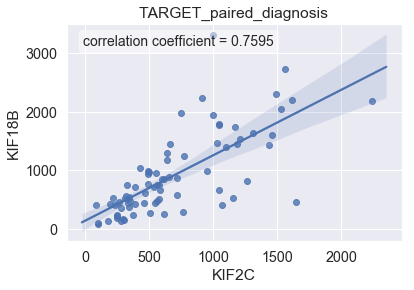

In [159]:
ax = sns.regplot(x = kif2c_d, y = kif18b_d)
ax.set(ylabel='KIF18B')
plt.title('TARGET_paired_diagnosis')

ax.hist(0, 50)
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

corr = (spearmanr(kif2c_d, kif18b_d)[0])
textstr = 'correlation coefficient = %.4f' %(corr)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.savefig('./TARGET_paired_diagnosis_corr.png', dpi=300, bbox_inches='tight')

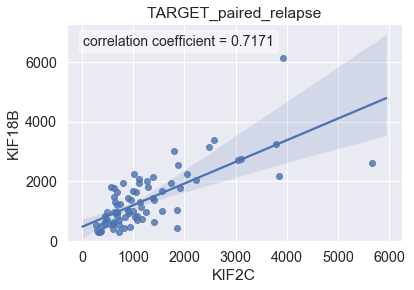

In [160]:
ax = sns.regplot(x = kif2c_r, y = kif18b_r)
ax.set(ylabel='KIF18B')
plt.title('TARGET_paired_relapse')

ax.hist(0, 50)
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

corr = (spearmanr(kif2c_r, kif18b_r)[0])
textstr = 'correlation coefficient = %.4f' %(corr)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.savefig('./TARGET_paired_relapse_corr.png', dpi=300, bbox_inches='tight')

In [122]:
print(stats.shapiro(kif2c_d))
print(stats.shapiro(kif18b_d))
print(stats.shapiro(kif2c_r))
print(stats.shapiro(kif18b_r))

print(spearmanr(kif2c_d, kif18b_d))
print(spearmanr(kif2c_r, kif18b_r))

(0.9129552841186523, 6.156965537229553e-05)
(0.8896463513374329, 6.546320037159603e-06)
(0.7639525532722473, 8.669364670588209e-10)
(0.8387405276298523, 1.063371612985975e-07)
SpearmanrResult(correlation=0.759451075240549, pvalue=1.1890165266007441e-15)
SpearmanrResult(correlation=0.7171249802828749, pvalue=2.1981566711567901e-13)


In [221]:
table = pd.merge(pset_paired, paired, left_index=True, right_index=True)

In [222]:
table.head()

,Sample ID_x,Relapse_x,index,Study ID,Patient ID,Sample ID_y,Diagnosis Age,Diagnosis Age (days),Alternative Therapy Given,Other Alternative Therapy Given,Analysis Cohort,BCR ABL1 Status,Bone Marrow Blasts Day 15,Bone Marrow Blasts Day 29,Bone Marrow Blasts Day 43,Bone Marrow Blasts Day 8,Bone Marrow Site of Relapse,Cancer Type,Cancer Type Detailed,Cell of tumor origin,CNS Site of Relapse,CNS Status,Congenital Abnormality,Death from Initial Pathologic Diagnosis Date,Time To Event (days),DNA Index,Ethnicity Category,ETV6-RUNX1 Fusion Status,First Event,Fraction Genome Altered,Karyotype,MLL Status,Molecular Subtype,MRD Percentage at end of Consolidation,MRD Percentage at end of Consolidation Sensitivity,MRD Percentage Day 29,MRD Percentage Day 29 Sensitivity,MRD Percentage Day 43,MRD Percentage Day 43 Sensitivity,MRD Percentage Day 8,MRD Percentage Day 8 Sensitivity,Mutation Count,Oncotree Code,Overall Survival Days,Overall Survival (Months),Overall Survival Status,Other Site of Relapse,Protocol,Race Category,Number of Samples Per Patient,Sex,TCF3-PBX1 Status,Testes Site of Relapse,Testicular Involvement,Trisomy 4_10,WBC,Hugo_Symbol,DDR1,RFC2,LOC652878,PAX8,GUCA1A,UBE1L,THRA,PTPN21,CCL5,CYP2E1,EPHB3,ESRRA,CYP2A6,SCARB1,TTLL12,MGC4677,WFDC2,MAPK1,ADAM32,SPATA17,MGC24975,PXK,VPS18,C9ORF30,HCP1,TIMD4,SLC39A5,ZDHHC11,ATP6V1E2,AFG3L1,PIGX,MGC42090,SLC39A13,VMD2L2,C6ORF199,CORO6,LOC653374,ALG10,C18ORF17,NEXN,C15ORF40,RAXL1,MFAP3,EYA3,GIMAP1,KLK8,CCDC65,FAM122C,CCDC11,ARMCX4,RBBP6,MGC16385,TRIOBP,CATSPER1,HOXD4,GSC,SP7,PDE7A,CNOT7,CRYZL1,PRSS33,C19ORF26,C8ORF45,TIRAP,LEAP2,MSI2,SCIN,CTCFL,LOC132321,FAM18B2,RDH10,SRRP35,FAM71A,C5ORF29,FLJ30901,C8ORF47,C1ORF65,RP1-172B20.3,TSSK3,WFDC6,CLEC12A,BRF1,C15ORF27,CALML6,NALP5,ODF4,CLEC4F,DEFB106A,WFDC9,NEDD1,TTLL10,CALR3,C10ORF25,ETV3,KLHL10,TM2D3,ZNF485,WDR17,FLJ35773,CDH23,ANKAR,MEGF11,ADMR,ESX1,C8ORF12,SCGB1C1,DNAJC5G,LOC126248,C9ORF65,MBD3L2,ADAMTSL1,MBD3L1,FAM46D,SERPINB11,C21ORF100,DSCR10,ABHD11,CENTB2,GAMT,PLCD3,IRF6,PTPRC,MAN1A2,RAPH1,SMCR8,LACTB,BNC1,MPP4,LACE1,IDI2,CYP11B1,TBN,COBL,SLAMF6,ZNF31,GPBAR1,RHBDL2,FRAS1,BRSK1,CRB2,KCNE4,CD300LG,SLC34A3,CPA6,CTA-250D10.11,HIPK1,MTBP,ACVR1C,TMEM74,TIGD4,ART5,FAM71C,C21ORF69,NALP11,ATP6V1C2,CLDN19,VTI1A,KIF6,IQCD,TAGAP,STON2,SERPINA12,LETM2,BSND,CLEC4C,CARD12,PRSS36,ZDHHC15,RAI1,ALS2CR7,ZNF570,C8ORF6,NUDT9P1,BTBD16,RTP3,C21ORF29,MIPOL1,C6ORF141,LOC200420,MYO3B,ADAM21,FLJ25801,ABCC13,IL12RB1,ALF,TRPV3,CNBD1,ABCC12,MMP21,MDAC1,GAS2L2,KCNG4,PXT1,...,DPPA5,C16ORF65,LOC643449,NUDT10,LSM11,ZNF582,LOC389834,LOC653071,LOC401056,BOLA2,LOC641748,LOC643542,LOC400120,ACPT,LOC285281,SRFBP1,PRAM1,LOC347273,ZNF615,LOC339240,LOC644112,C19ORF45,SNORA28,OR2W3,LOC440905,LOC553103,LOC647786,TMEM16G,PXDNL,ACOT6,LOC647262,SRD5A2L2,LOC401588,RAB3C,MGC39715,RHOV,LOC389073,RP11-308D16.4,LOC339316,PAQR7,LOC647510,LOC652837,LOC113386,WDR69,LIPI,LOC401356,ADAMTSL5,WFDC5,ANKRD33,LOC388720,LOC440894,TMEM162,SLC26A9,ZFPM1,LOC199899,CXORF50,CBLN2,LOC645620,CCBE1,LOC401317,LOC283904,NALP4,FAM19A4,ST8SIA6,LOC646968,LOC255275,LOC650195,LOC283278,LOC647974,NRG4,C1ORF141,ZNF600,LOC120376,EID-3,LOC647135,GSTA2,MGC27016,KISS1R,LOC284948,LOC642398,GPR137C,TSSK4,LOC253012,NBPF9,CCDC37,GCRG224,C15ORF21,LOC650269,FLJ38028,LOC653086,ARL5B,LOC391269,LOC650874,PGLYRP2,RNF207,OTOS,LOC652905,RNF148,VWCE,LOC400796,DCST2,LOC644829,RDH12,RP11-38L15.1,LOC441242,LOC150084,C2ORF38,LOC643831,FLJ34515,LOC387978,FLJ16734,WDR63,NPW,FLJ16423,FAM24A,UTS2D,ZNF283,MGC33407,FLJ39822,C17ORF55,C11ORF38,LOC283335,C1QDC2,LOC220729,LOC286109,FLJ27352,RP5-1103G7.6,FREM3,LOC648832,FAM7A1,LOC641518,CERKL,LOC642237,PRH2,LOC643406,LOC440268,KCNQ1OT1,LOC642891,ZNF418,LOC643675,LOC349136,C10ORF130,KIAA1841,ADH1C,FLJ39639,LOC646470,LOC158230,LOC285957,SPACA3,LOC145694,LOC642333,PRAP1,LOC285431,FAM47A,TMEM132E,PYDC1,LOC388481,LOC389070,C21ORF70,LOC650794,DNHD2,LOC643037,PGBD4,LOC642981,ZCWPW2,LOC644241,C13ORF26,LOC646865,LOC644529,LOC647263,LOC653527,LOC645106,LOC285286,LOC645032,LOC541472,C20ORF175,LOC144766,KRT222P,AM

In [260]:
r = paired['Relapse'] == True

In [225]:
m = table['Sex'] == 'Male'

In [226]:
table['Race Category'].unique()

array(['White', 'Unknown', 'Black or African American', 'Asian'],
      dtype=object)

In [245]:
table['MLL Status'].unique()

array(['Unknown', 'Negative', 'Positive'], dtype=object)

In [261]:
mll = paired['MLL Status'] == 'Negative'

In [257]:
race = table['Race Category'] == 'Black or African American'

In [228]:
len(table[r][m])

C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


43

In [240]:
a = table['Diagnosis Age']<10.0

In [263]:
len(paired[r][mll])

C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


86

In [265]:
chisquare([17.2,22.4])

Power_divergenceResult(statistic=0.6828282828282828, pvalue=0.40861451317369635)

---
## GSE60926

In [200]:
%%R

gse <- getGEO("GSE60926",GSEMatrix=TRUE)
gse <- gse[[1]]

#exp data
eset <- exprs(gse)

#probe id to gene symbol
fset <- fData(gse)

symbols <- fset[,"Gene Symbol"]
rownames(eset) <- symbols

pset <- phenoData(gse)

eset <- 2^(eset) #denomalizing

pset_d = pset$'source_name_ch1' == 'ALL - bone marrow - Diagnosis'
pset_r = pset$'source_name_ch1' == 'ALL - bone marrow - Relapse'

eset_d = eset[,pset$'source_name_ch1' == 'ALL - bone marrow - Diagnosis']
eset_r = eset[,pset$'source_name_ch1' == 'ALL - bone marrow - Relapse']

kif2c_d = eset_d[which(rownames(eset_d) == "KIF2C")[1],]
kif2c_r = eset_r[which(rownames(eset_r) == "KIF2C")[1],]

kif18b_d = eset_d[which(rownames(eset_d) == "KIF18B")[1],]
kif18b_r = eset_r[which(rownames(eset_r) == "KIF18B")[1],]

ncaph_d = eset_d[which(rownames(eset_d) == "NCAPH")[1],]
ncaph_r = eset_r[which(rownames(eset_r) == "NCAPH")[1],]

data <- data.frame(
  name=c( rep("KIF2C_diagnosis",22), rep("KIF2C_relapse",20),
         rep("KIF18B_diagnosis",22), rep("KIF18B_relapse",20),
        rep("NCAPH_diagnosis",22), rep("NCAPH_relapse",20)),
  value=c( kif2c_d, kif2c_r, 
          kif18b_d, kif18b_r, 
          ncaph_d, ncaph_r)
)

write.csv(data, './GSE60926.csv', row.names=FALSE)

In [201]:
%R -o kif2c_d -o kif2c_r -o kif18b_d -o kif18b_r

kif2c_d = np.asarray(kif2c_d)
kif2c_r = np.asarray(kif2c_r)
kif18b_d = np.asarray(kif18b_d)
kif18b_r = np.asarray(kif18b_r)

---
## Correlation

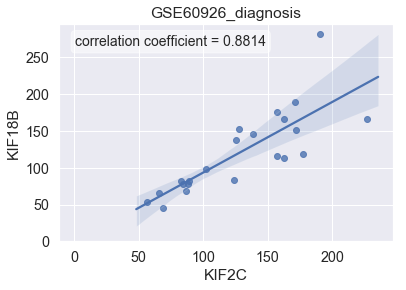

In [202]:
ax = sns.regplot(x = kif2c_d, y = kif18b_d)
ax.set(xlabel='KIF2C')
ax.set(ylabel='KIF18B')
plt.title('GSE60926_diagnosis')

ax.hist(0, 50)
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

corr = (spearmanr(kif2c_d, kif18b_d)[0])
textstr = 'correlation coefficient = %.4f' %(corr)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.savefig('./GSE60926_diagnosis_corr.png', dpi=300, bbox_inches='tight')

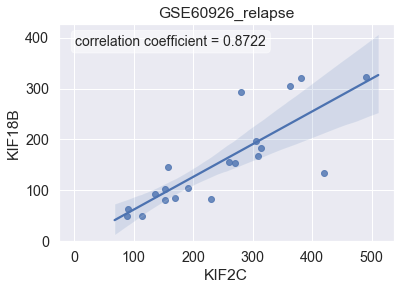

In [203]:
ax = sns.regplot(x = kif2c_r, y = kif18b_r)
ax.set(xlabel='KIF2C')
ax.set(ylabel='KIF18B')
plt.title('GSE60926_relapse')

ax.hist(0, 50)
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

corr = (spearmanr(kif2c_r, kif18b_r)[0])
textstr = 'correlation coefficient = %.4f' %(corr)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.savefig('./GSE60926_relapse_corr.png', dpi=300, bbox_inches='tight')

In [195]:
print(stats.shapiro(kif2c_d))
print(stats.shapiro(kif18b_d))
print(stats.shapiro(kif2c_r))
print(stats.shapiro(kif18b_r))

print(spearmanr(kif2c_d, kif18b_d))
print(spearmanr(kif2c_r, kif18b_r))

(0.9501525163650513, 0.3180525004863739)
(0.917116641998291, 0.06626894325017929)
(0.9520552754402161, 0.3993689715862274)
(0.8720179796218872, 0.012751078233122826)
SpearmanrResult(correlation=0.8814229249011858, pvalue=6.028030755762958e-08)
SpearmanrResult(correlation=0.8721804511278194, pvalue=5.3897404423302e-07)


---
## GSE28460

In [204]:
%%R

gse <- getGEO("GSE28460",GSEMatrix=TRUE)
gse <- gse[[1]]

#exp data
eset <- exprs(gse)

#probe id to gene symbol
fset <- fData(gse)

symbols <- fset[,"Gene Symbol"]
rownames(eset) <- symbols

pset <- phenoData(gse)

pset_d = pset$'source_name_ch1' == 'diagnosis'
pset_r = pset$'source_name_ch1' == 'relapse'

eset_d = eset[,pset$'source_name_ch1' == 'diagnosis']
eset_r = eset[,pset$'source_name_ch1' == 'relapse']

kif2c_d = eset_d[which(rownames(eset_d) == "KIF2C")[1],]
kif2c_r = eset_r[which(rownames(eset_r) == "KIF2C")[1],]

kif18b_d = eset_d[which(rownames(eset_d) == "KIF18B")[1],]
kif18b_r = eset_r[which(rownames(eset_r) == "KIF18B")[1],]

ncaph_d = eset_d[which(rownames(eset_d) == "NCAPH")[1],]
ncaph_r = eset_r[which(rownames(eset_r) == "NCAPH")[1],]

data <- data.frame(
  name=c( rep("KIF2C_diagnosis",49), rep("KIF2C_relapse",49),
         rep("KIF18B_diagnosis",49), rep("KIF18B_relapse",49),
        rep("NCAPH_diagnosis",49), rep("NCAPH_relapse",49)),
  value=c( kif2c_d, kif2c_r, 
          kif18b_d, kif18b_r, 
          ncaph_d, ncaph_r)
)

write.csv(data, './GSE28460.csv', row.names=FALSE)

In [205]:
%R -o kif2c_d -o kif2c_r -o kif18b_d -o kif18b_r

kif2c_d = np.asarray(kif2c_d)
kif2c_r = np.asarray(kif2c_r)
kif18b_d = np.asarray(kif18b_d)
kif18b_r = np.asarray(kif18b_r)

---
## Correlation

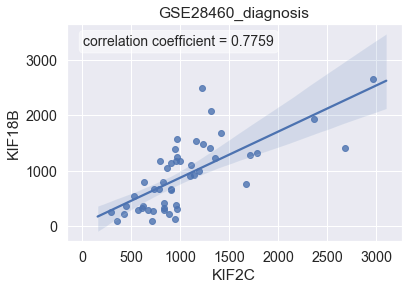

In [206]:
ax = sns.regplot(x = kif2c_d, y = kif18b_d)
ax.set(xlabel='KIF2C')
ax.set(ylabel='KIF18B')
plt.title('GSE28460_diagnosis')

ax.hist(0, 50)
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

corr = (spearmanr(kif2c_d, kif18b_d)[0])
textstr = 'correlation coefficient = %.4f' %(corr)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.savefig('./GSE28460_diagnosis_corr.png', dpi=300, bbox_inches='tight')

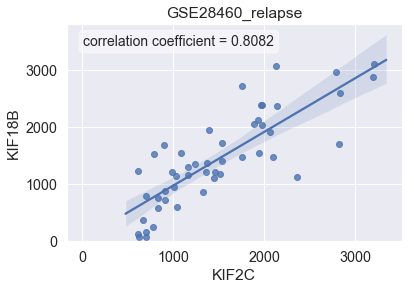

In [207]:
ax = sns.regplot(x = kif2c_r, y = kif18b_r)
ax.set(xlabel='KIF2C')
ax.set(ylabel='KIF18B')
plt.title('GSE28460_relapse')

ax.hist(0, 50)
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

corr = (spearmanr(kif2c_r, kif18b_r)[0])
textstr = 'correlation coefficient = %.4f' %(corr)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.savefig('./GSE28460_relapse_corr.png', dpi=300, bbox_inches='tight')

In [208]:
print(stats.shapiro(kif2c_d))
print(stats.shapiro(kif18b_d))
print(stats.shapiro(kif2c_r))
print(stats.shapiro(kif18b_r))

print(spearmanr(kif2c_d, kif18b_d))
print(spearmanr(kif2c_r, kif18b_r))

(0.8336684703826904, 6.87734063831158e-06)
(0.9278688430786133, 0.00511350529268384)
(0.9213703870773315, 0.0029633936937898397)
(0.9670682549476624, 0.1846027374267578)
SpearmanrResult(correlation=0.7759183673469386, pvalue=5.8086067315569385e-11)
SpearmanrResult(correlation=0.8081632653061224, pvalue=2.2155022018183672e-12)


---
## Boxplot

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

KIF2C_diagnosis v.s. KIF2C_relapse: t-test independent samples, P_val=8.945e-05 stat=-4.357e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

KIF18B_diagnosis v.s. KIF18B_relapse: t-test independent samples, P_val=1.421e-01 stat=-1.498e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

NCAPH_diagnosis v.s. NCAPH_relapse: t-test independent samples, P_val=6.395e-04 stat=-3.705e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

KIF2C_diagnosis v.s. KIF2C_relapse: t-test independent

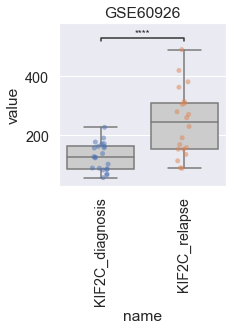

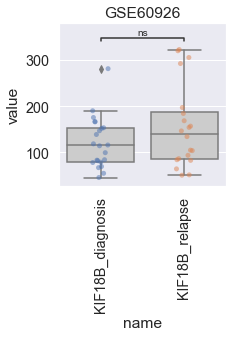

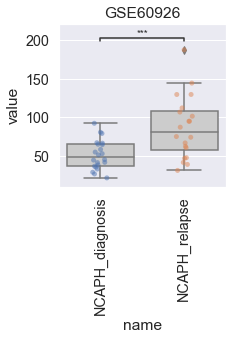

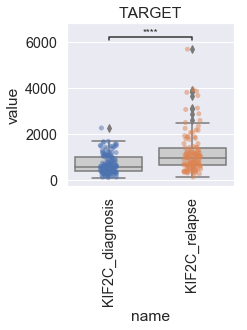

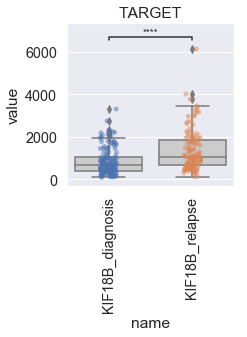

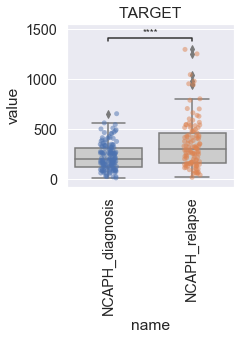

In [33]:
dfs = ['GSE60926', 'TARGET']
for k in dfs:
    table = pd.read_csv('./%s.csv' %k)
    
    kif2c = []
    kif18b = []
    ncaph = []
    
    gene = [kif2c, kif18b, ncaph]
    name = ['KIF2C', 'KIF18B', 'NCAPH']

    for i in range(0, len(gene)):
        dia = table['name'] == ('%s_diagnosis' %name[i].upper())
        rel = table['name'] == ('%s_relapse' %name[i].upper())
        gene[i] = table[dia].append(table[rel])
        
    for i in range(0,len(gene)):
        plt.subplots(figsize = (3, 3))

        f1 = sns.boxplot(data=gene[i], x = gene[i]['name'], y = gene[i]['value'], color="0.8")
        #f1.set_ylim(0, max(max(smc2['value']),max(smc4['value']))+100)
        f1.set_title('%s' %k)
        sns.stripplot(data=gene[i], x = gene[i]['name'], y = gene[i]['value'], jitter=True, alpha=0.5)
        plt.xticks(rotation=90)
        
        add_stat_annotation(f1, data=gene[i], x = gene[i]['name'], y = gene[i]['value'],
                    box_pairs=[(("%s_diagnosis" %name[i].upper()), ("%s_relapse" %name[i].upper()))
                                ],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)

        plt.savefig('./%s_%s.png' %(k, name[i]), dpi=300, bbox_inches='tight')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

KIF2C_diagnosis v.s. KIF2C_relapse: t-test paired samples, P_val=1.977e-04 stat=-4.031e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

KIF18B_diagnosis v.s. KIF18B_relapse: t-test paired samples, P_val=4.519e-04 stat=-3.767e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

NCAPH_diagnosis v.s. NCAPH_relapse: t-test paired samples, P_val=6.763e-04 stat=-3.635e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

KIF2C_diagnosis v.s. KIF2C_relapse: t-test paired samples, P_val=1.49

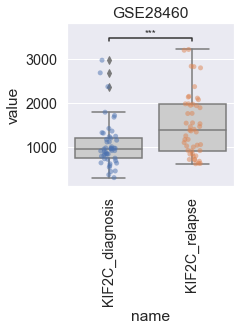

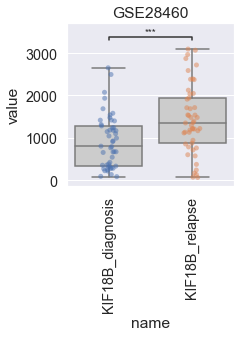

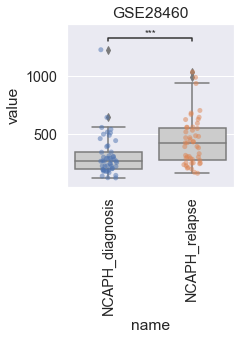

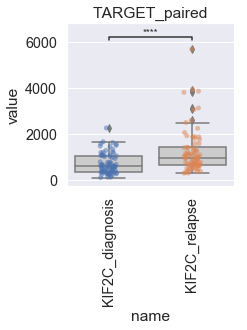

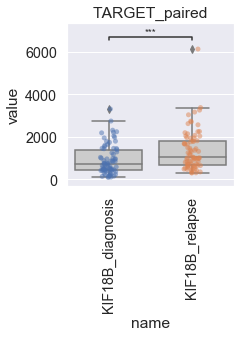

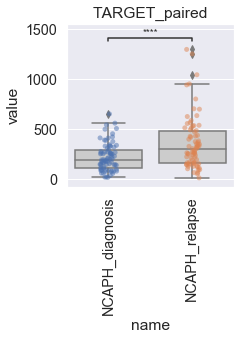

In [34]:
dfs = ['GSE28460', 'TARGET_paired']
for k in dfs:
    table = pd.read_csv('./%s.csv' %k)
    
    kif2c = []
    kif18b = []
    ncaph = []
    
    gene = [kif2c, kif18b, ncaph]
    name = ['KIF2C', 'KIF18B', 'NCAPH']

    for i in range(0, len(gene)):
        dia = table['name'] == ('%s_diagnosis' %name[i].upper())
        rel = table['name'] == ('%s_relapse' %name[i].upper())
        gene[i] = table[dia].append(table[rel])
        
    for i in range(0,len(gene)):
        plt.subplots(figsize = (3, 3))

        f1 = sns.boxplot(data=gene[i], x = gene[i]['name'], y = gene[i]['value'], color="0.8")
        #f1.set_ylim(0, max(max(smc2['value']),max(smc4['value']))+100)
        f1.set_title('%s' %k)
        sns.stripplot(data=gene[i], x = gene[i]['name'], y = gene[i]['value'], jitter=True, alpha=0.5)
        plt.xticks(rotation=90)
        
        add_stat_annotation(f1, data=gene[i], x = gene[i]['name'], y = gene[i]['value'],
                    box_pairs=[(("%s_diagnosis" %name[i].upper()), ("%s_relapse" %name[i].upper()))
                                ],
                    test='t-test_paired', text_format='star', loc='inside', verbose=2)

        plt.savefig('./%s_%s.png' %(k, name[i]), dpi=300, bbox_inches='tight')